In [1]:
import openpmd_api as io
import numpy as np

print("openPMD-api: {}"
      .format(io.__version__))
print("openPMD-api backend variants: {}"
      .format(io.variants))

openPMD-api: 0.14.5
openPMD-api backend variants: {'adios1': True, 'adios2': True, 'hdf5': True, 'json': True, 'mpi': False}


In [2]:
series = io.Series("./from_cloud/simData_68500.bp",
                       io.Access.read_only)
print("Read a Series with openPMD standard version %s" %
      series.openPMD)

print("The Series contains {0} iterations:".format(len(series.iterations)))
for i in series.iterations:
    print("\t {0}".format(i))
print("")

Read a Series with openPMD standard version 1.1.0
The Series contains 1 iterations:
	 68500



In [3]:
i = series.iterations[68500]
print("Iteration 10000 contains {0} meshes:".format(len(i.meshes)))
for m in i.meshes:
    print("\t {0}".format(m))
print("")
print("Iteration 10000 contains {0} particle species:".format(
    len(i.particles)))
for ps in i.particles:
    print("\t {0}".format(ps))
    print("With records:")
    for r in i.particles[ps]:
        print("\t {0}".format(r))

Iteration 10000 contains 1 meshes:
	 picongpu_idProvider

Iteration 10000 contains 1 particle species:
	 b_all
With records:
	 charge
	 mass
	 momentum
	 momentumPrev1
	 position
	 positionOffset
	 radiationMask
	 weighting


In [4]:
electrons = i.particles["b_all"]
charge = electrons["charge"][io.Mesh_Record_Component.SCALAR]
#charge = charge[0:7]
#charge = electrons["charge"]
series.flush()
for a in charge.attributes:
    print("    {0}".format(a))
print(charge.get_attribute('shape'))
print("And the first electron particle has a charge {}"
      .format(charge.get_attribute('value')))
print("")
del charge

    macroWeighted
    shape
    timeOffset
    unitDimension
    unitSI
    value
    weightingPower
345007
And the first electron particle has a charge -0.0015508142532780766



In [5]:
particles = i.particles["b_all"]

particle_tensor = np.stack((particles["position"]["x"],
                            particles["position"]["y"],
                            particles["position"]["z"],
                            particles["momentum"]["x"],
                            particles["momentum"]["y"],
                            particles["momentum"]["z"]), axis=-1)
    


In [7]:
print(np.isnan(particle_tensor).any())
f = open("demofile2.txt", "a")

for i in range(particle_tensor.shape[0]):
    f.write(" ".join([str(particle_tensor[i,k]) for k in range(6)]))
f.close()

False


In [ ]:
print(particle_tensor.shape)

print(particle_tensor[0,:])

In [ ]:
np.save("./particle_data", particle_tensor)

In [5]:
particle_tensor = np.load("./particle_data.npy")

for i in range(particle_tensor.shape[1]):
    minv = np.min(particle_tensor[:,i])
    maxv = np.max(particle_tensor[:,i])
    particle_tensor[:,i] = (particle_tensor[:,i]-minv)/(maxv-minv)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as tick
from matplotlib import cm

In [24]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['lines.linewidth']=6
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [17]:
def plot_3D(particle_tensor, color_component=-1):

    fig = plt.figure(figsize=(24,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    comp = color_component

    norm = matplotlib.colors.Normalize(vmin=np.min(particle_tensor[:, comp]),
                                   vmax=np.max(particle_tensor[:, comp]))

    ax.scatter(particle_tensor[:, 0], particle_tensor[:, 1], particle_tensor[:, 2], 
           c=plt.cm.jet(norm(particle_tensor[:, comp])), s=20, alpha=0.5)
    ax.view_init(40, 200)

    m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    m.set_array([])
    cb = plt.colorbar(m, shrink=0.6, pad=0.01)
    cb.ax.tick_params(labelsize=23)
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel('Momentum Z', fontsize=25)

    ax.set_xlabel('x', fontsize=25, linespacing=5.2)
    #ax.set_xlabel('', fontsize=25, linespacing=5.2)
    ax.set_ylabel('y', fontsize=25, linespacing=5.2)
    ax.set_zlabel('z', fontsize=25, linespacing=5.2)
    ax.dist = 10

    ax.xaxis.set_tick_params(labelsize=23)
    ax.yaxis.set_tick_params(labelsize=23)
    ax.zaxis.set_tick_params(labelsize=23)
    ax.xaxis.labelpad=30
    ax.yaxis.labelpad=30
    ax.zaxis.labelpad=30

    ax.tick_params(axis='both', which='major', pad=10)

    ax.xaxis._axinfo['label']['space_factor'] = 5.0
    ax.yaxis._axinfo['label']['space_factor'] = 5.0
    ax.zaxis._axinfo['label']['space_factor'] = 5.0

    ax.set_title('GT', fontsize=25)

    plt.show()

In [19]:
pc = particle_tensor
slice_along = 2 #z: 2
num_slices = 10

slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

for ind in range(len(slices)-1):
    pc_[:, -1][(pc_[:, -3]>=slices[ind]) & (pc_[:, -3]<=slices[ind+1])] = ind
pc_[:, -1][(pc_[:, -3]>=slices[-1])] = len(slices) - 1

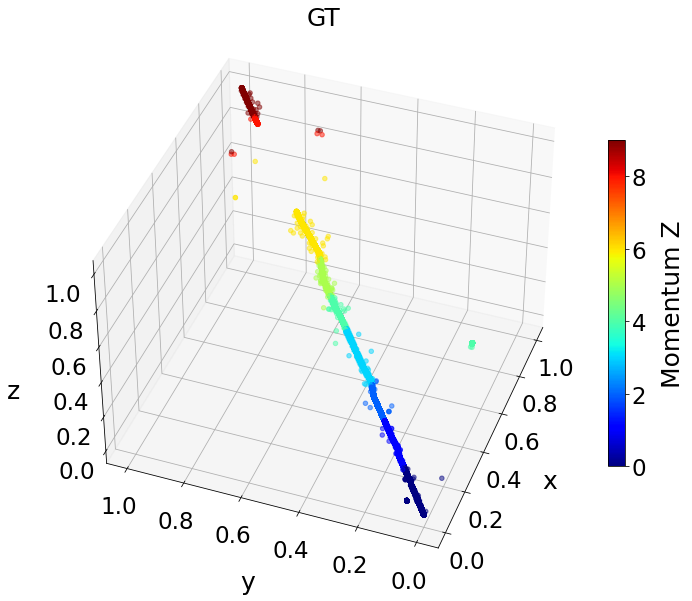

In [20]:
plot_3D(pc_, color_component=-1)

In [42]:
def plot_per_slice(pc, slice_along, num_slices, comp_of_interest, axs):
    if comp_of_interest != None:
        comp_of_interest = comp_of_interest - 1

    slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
    pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

    for ind in range(len(slices)-1):
        pc_[:, -1][(pc_[:, -3]>=slices[ind]) & (pc_[:, -3]<=slices[ind+1])] = ind
    pc_[:, -1][(pc_[:, -3]>=slices[-1])] = len(slices) - 1

    if comp_of_interest != None:
        mean_energy = [np.mean(pc_[:, comp_of_interest][pc_[:,-1]==ind]) for ind in range(len(slices))]
        std_energy = [np.std(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if pc_[:, comp_of_interest][pc_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices)) ]
        axs.plot([slice_ for slice_ in slices], mean_energy)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z [mm]')
        axs.set_ylabel('Mean Energy [MeV]')
        #axs.legend(prop={'size': 20})


    if comp_of_interest == None:
        num_particles = [pc_[pc_[:,-1]==ind].shape[0] for ind in range(len(slices))]
        axs.plot([slice_ for slice_ in slices], num_particles)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z [mm]')
        axs.set_ylabel('Number of particles')
        #axs.legend(prop={'size': 20})

In [45]:
def plot_2D(pc, comp_x, comp_y, axs, label_x, label_y):
    axs.scatter(pc[:,comp_x], pc[:,comp_y], s=15, alpha=0.2)
    axs.tick_params(axis='y', which='major', rotation=45)
    axs.grid(True)
    axs.set_xlabel(label_x)
    axs.set_ylabel(label_y)
    #axs.legend(prop={'size': 20})

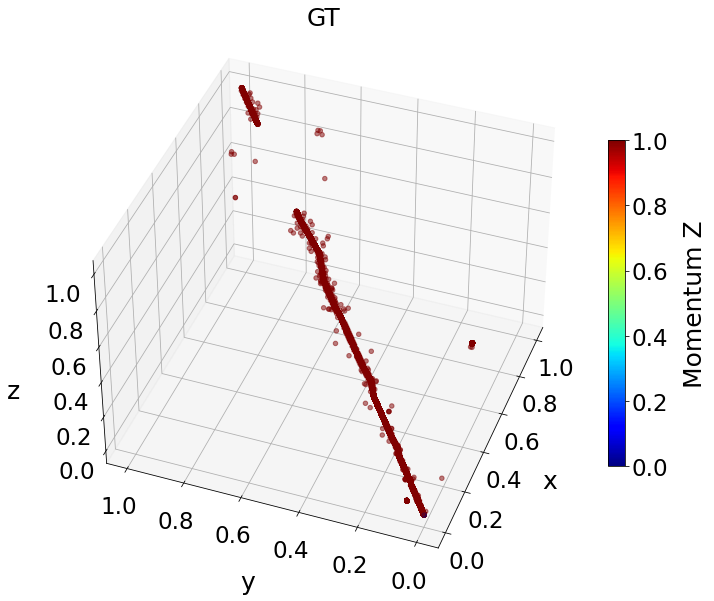

In [47]:
plot_3D(particle_tensor)

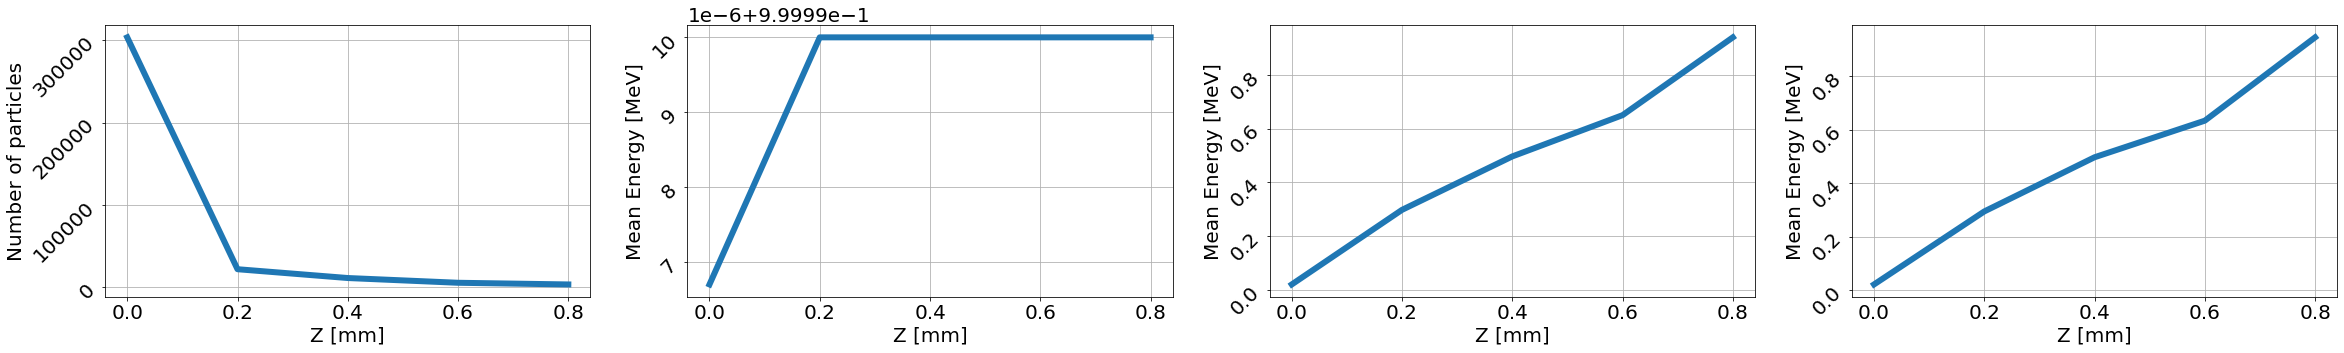

In [48]:
pc = particle_tensor
slice_along = 2 #z: 2
num_slices = 5
comp_of_interest = -3
figsize1 = 40
figsize2 = 5

fig, axs = plt.subplots(1, 4, figsize=(figsize1,figsize2))
plot_per_slice(axs=axs[0], comp_of_interest=None, 
               num_slices=num_slices, pc=particle_tensor, slice_along=slice_along)
for i in range(1,4,1):
    plot_per_slice(axs=axs[i], comp_of_interest=-1*i, 
               num_slices=num_slices, pc=particle_tensor, slice_along=slice_along)
plt.show()

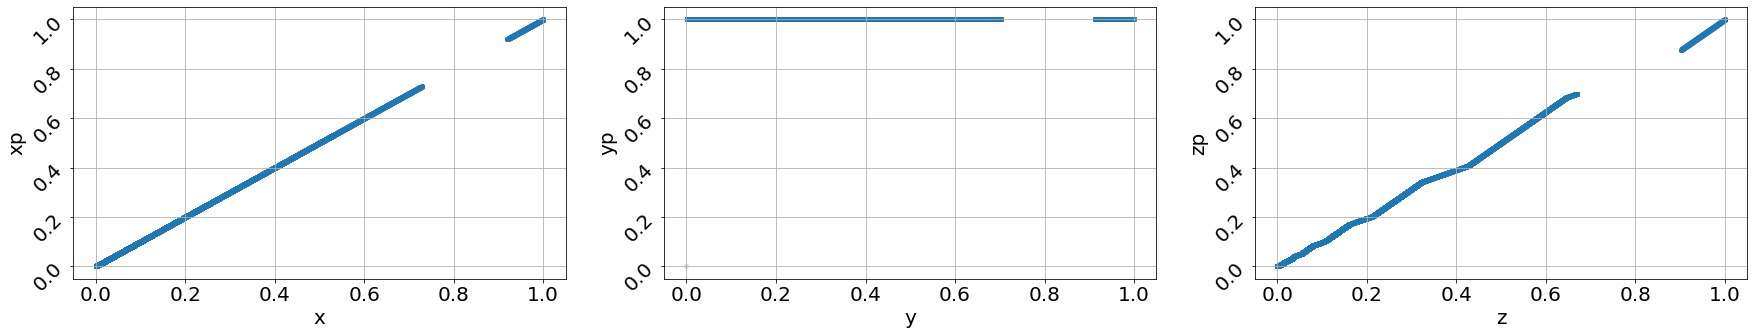

In [49]:
figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))
labels_x = ['x', 'y', 'z']
labels_y = ['xp', 'yp', 'zp']

for i in range(3):
    plot_2D(axs=axs[i], comp_x=i, comp_y=0-i,
            pc=particle_tensor, label_x=labels_x[i], label_y=labels_y[i])
plt.show()